In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

resolution = 50         # pixels/μm

dpml = 1.0              # PML thickness
dsub = 2.0              # substrate thickness
dpad = 2.0              # padding between grating and PML

lcen = 0.5              # center wavelength
fcen = 1/lcen           # center frequency
df = 0.2*fcen           # frequency width

focal_length = 200      # focal length of metalens
spot_length = 100       # far field line length
ff_res = 10             # far field resolution (points/μm)

k_point = mp.Vector3(0,0,0)

glass = mp.Medium(index=1.5)

pml_layers = [mp.PML(thickness=dpml,direction=mp.X)]

symmetries=[mp.Mirror(mp.Y)]

def grating(gp,gh,gdc_list):
  sx = dpml+dsub+gh+dpad+dpml
  src_pt = mp.Vector3(-0.5*sx+dpml+0.5*dsub)
  mon_pt = mp.Vector3(0.5*sx-dpml-0.5*dpad)
  geometry = [mp.Block(material=glass,
                       size=mp.Vector3(dpml+dsub,mp.inf,mp.inf),
                       center=mp.Vector3(-0.5*sx+0.5*(dpml+dsub)))]

  num_cells = len(gdc_list)
  if num_cells == 1:
    sy = gp
    cell_size = mp.Vector3(sx,sy,0)

    sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                         component=mp.Ez,
                         center=src_pt,
                         size=mp.Vector3(y=sy))]

    sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=pml_layers,
                        k_point=k_point,
                        default_material=glass,
                        sources=sources,
                        symmetries=symmetries)

    flux_obj = sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=sy)))

    sim.run(until_after_sources=50)
    
    input_flux = mp.get_fluxes(flux_obj)
  
    sim.reset_meep()

    geometry.append(mp.Block(material=glass, size=mp.Vector3(gh,gdc_list[0]*gp,mp.inf), center=mp.Vector3(-0.5*sx+dpml+dsub+0.5*gh)))

    sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        k_point=k_point,
                        sources=sources,
                        symmetries=symmetries)

    flux_obj = sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=sy)))

    sim.run(until_after_sources=200)

    freqs = mp.get_eigenmode_freqs(flux_obj)
    res = sim.get_eigenmode_coefficients(flux_obj, [1], eig_parity=mp.ODD_Z+mp.EVEN_Y)
    coeffs = res.alpha

    mode_tran = abs(coeffs[0,0,0])**2/input_flux[0]
    mode_phase = np.angle(coeffs[0,0,0])
    if mode_phase > 0:
      mode_phase -= 2*np.pi
  
    return mode_tran, mode_phase
  
  else:    
    sy = num_cells*gp
    cell_size = mp.Vector3(sx,sy,0)

    sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                         component=mp.Ez,
                         center=src_pt,
                         size=mp.Vector3(y=sy))]

    for j in range(num_cells):
      geometry.append(mp.Block(material=glass,
                               size=mp.Vector3(gh,gdc_list[j]*gp,mp.inf),
                               center=mp.Vector3(-0.5*sx+dpml+dsub+0.5*gh,-0.5*sy+(j+0.5)*gp)))

    sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        k_point=k_point,
                        sources=sources,
                        symmetries=symmetries)

    n2f_obj = sim.add_near2far(fcen, 0, 1, mp.Near2FarRegion(center=mon_pt, size=mp.Vector3(y=sy)))

    sim.run(until_after_sources=500)
    
    return abs(sim.get_farfields(n2f_obj, ff_res, center=mp.Vector3(focal_length), size=mp.Vector3(spot_length))['Ez'])**2

In [2]:
gp = 0.3                       # grating periodicity
gh = 1.8                       # grating height
gdc = np.linspace(0.1,0.9,30)  # grating duty cycle

mode_tran = np.empty((gdc.size))
mode_phase = np.empty((gdc.size))
for n in range(gdc.size):
  mode_tran[n], mode_phase[n] = grating(gp,gh,[gdc[n]])

-----------
Initializing structure...
run 0 finished at t = 75.0 (7500 timesteps)
-----------
Initializing structure...
run 0 finished at t = 225.0 (22500 timesteps)
-----------
Initializing structure...
run 0 finished at t = 75.0 (7500 timesteps)
-----------
Initializing structure...
run 0 finished at t = 225.0 (22500 timesteps)
-----------
Initializing structure...
run 0 finished at t = 75.0 (7500 timesteps)
-----------
Initializing structure...
run 0 finished at t = 225.0 (22500 timesteps)
-----------
Initializing structure...
run 0 finished at t = 75.0 (7500 timesteps)
-----------
Initializing structure...
run 0 finished at t = 225.0 (22500 timesteps)
-----------
Initializing structure...
run 0 finished at t = 75.0 (7500 timesteps)
-----------
Initializing structure...
run 0 finished at t = 225.0 (22500 timesteps)
-----------
Initializing structure...
run 0 finished at t = 75.0 (7500 timesteps)
-----------
Initializing structure...
run 0 finished at t = 225.0 (22500 timesteps)
----

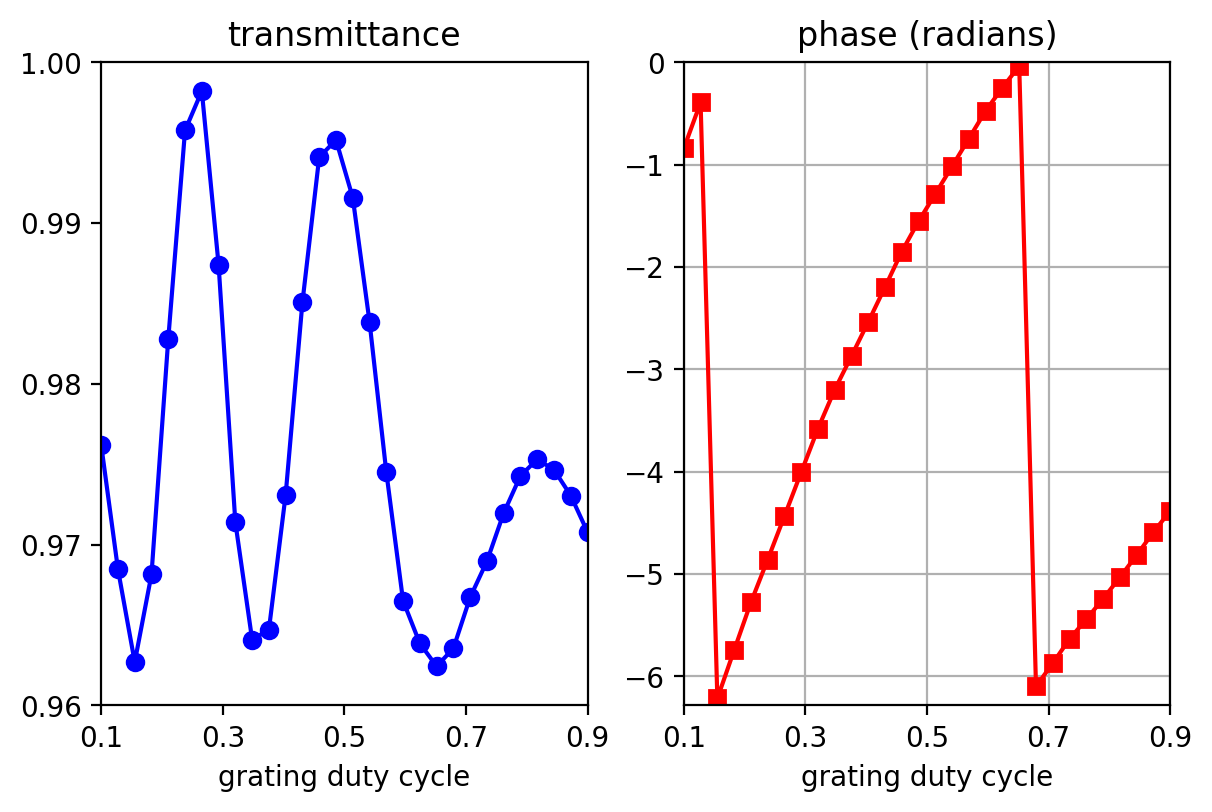

In [3]:
plt.figure(dpi=200)
plt.subplot(1,2,1)
plt.plot(gdc, mode_tran, 'bo-')
plt.xlim(gdc[0],gdc[-1])
plt.xticks([t for t in np.linspace(0.1,0.9,5)])
plt.xlabel("grating duty cycle")
plt.ylim(0.96,1.00)
plt.yticks([t for t in np.linspace(0.96,1.00,5)])
plt.title("transmittance")

plt.subplot(1,2,2)
plt.plot(gdc, mode_phase, 'rs-')
plt.grid(True)
plt.xlim(gdc[0],gdc[-1])
plt.xticks([t for t in np.linspace(0.1,0.9,5)])
plt.xlabel("grating duty cycle")
plt.ylim(-2*np.pi,0)
plt.yticks([t for t in np.linspace(-6,0,7)])
plt.title("phase (radians)")

plt.tight_layout(pad=0.5)
plt.show()

In [4]:
gdc_new = np.linspace(0.16,0.65,500)
mode_phase_interp = np.interp(gdc_new, gdc, mode_phase)
print("phase-range:, {:.6f}".format(mode_phase_interp.max()-mode_phase_interp.min()))

phase_tol = 1e-2
num_cells = [100,200,400]
ff_nc = np.empty((spot_length*ff_res,len(num_cells)))

for k in range(len(num_cells)):
  gdc_list = []
  for j in range(-num_cells[k],num_cells[k]+1):
    phase_local = 2*np.pi/lcen * (focal_length-((j*gp)**2 + focal_length**2)**0.5)  # local phase at the center of the j'th unit cell
    phase_mod = phase_local % (-2*np.pi)                                            # restrict phase to [-2*pi,0]
    if phase_mod > mode_phase_interp.max():
      phase_mod = mode_phase_interp.max()
    if phase_mod < mode_phase_interp.min():
      phase_mod = mode_phase_interp.min()
    idx = np.transpose(np.nonzero(np.logical_and(mode_phase_interp > phase_mod-phase_tol, mode_phase_interp < phase_mod+phase_tol)))
    gdc_list.append(gdc_new[idx[0][0]])

  ff_nc[:,k] = grating(gp,gh,gdc_list)

phase-range:, 6.086174
-----------
Initializing structure...
Meep progress: 6.49/525.0 = 1.2% done in 4.0s, 320.1s to go
Meep progress: 13.18/525.0 = 2.5% done in 8.0s, 311.1s to go
Meep progress: 19.5/525.0 = 3.7% done in 12.0s, 311.5s to go
Meep progress: 25.84/525.0 = 4.9% done in 16.0s, 309.5s to go
Meep progress: 32.64/525.0 = 6.2% done in 20.0s, 302.0s to go
Meep progress: 39.84/525.0 = 7.6% done in 24.0s, 292.6s to go
Meep progress: 46.93/525.0 = 8.9% done in 28.0s, 285.5s to go
Meep progress: 53.980000000000004/525.0 = 10.3% done in 32.0s, 279.5s to go
Meep progress: 61.08/525.0 = 11.6% done in 36.0s, 273.7s to go
Meep progress: 68.07000000000001/525.0 = 13.0% done in 40.0s, 268.8s to go
Meep progress: 75.26/525.0 = 14.3% done in 44.0s, 263.2s to go
Meep progress: 82.34/525.0 = 15.7% done in 48.0s, 258.3s to go
Meep progress: 89.39/525.0 = 17.0% done in 52.0s, 253.6s to go
Meep progress: 96.49000000000001/525.0 = 18.4% done in 56.1s, 248.9s to go
Meep progress: 103.600000000000

Meep progress: 173.79/525.0 = 33.1% done in 196.3s, 396.6s to go
Meep progress: 177.36/525.0 = 33.8% done in 200.3s, 392.5s to go
Meep progress: 180.83/525.0 = 34.4% done in 204.3s, 388.8s to go
Meep progress: 184.37/525.0 = 35.1% done in 208.3s, 384.8s to go
Meep progress: 187.97/525.0 = 35.8% done in 212.3s, 380.6s to go
Meep progress: 191.65/525.0 = 36.5% done in 216.3s, 376.2s to go
Meep progress: 195.34/525.0 = 37.2% done in 220.3s, 371.8s to go
Meep progress: 198.99/525.0 = 37.9% done in 224.3s, 367.5s to go
Meep progress: 202.58/525.0 = 38.6% done in 228.3s, 363.3s to go
Meep progress: 206.13/525.0 = 39.3% done in 232.3s, 359.3s to go
Meep progress: 209.53/525.0 = 39.9% done in 236.3s, 355.8s to go
Meep progress: 213.18/525.0 = 40.6% done in 240.3s, 351.5s to go
Meep progress: 216.84/525.0 = 41.3% done in 244.3s, 347.2s to go
Meep progress: 220.58/525.0 = 42.0% done in 248.3s, 342.7s to go
Meep progress: 224.33/525.0 = 42.7% done in 252.3s, 338.2s to go
Meep progress: 228.01/525

Meep progress: 48.57/525.0 = 9.3% done in 112.4s, 1102.6s to go
Meep progress: 50.33/525.0 = 9.6% done in 116.4s, 1098.0s to go
Meep progress: 52.120000000000005/525.0 = 9.9% done in 120.4s, 1092.7s to go
Meep progress: 53.870000000000005/525.0 = 10.3% done in 124.4s, 1088.3s to go
Meep progress: 55.59/525.0 = 10.6% done in 128.4s, 1084.6s to go
Meep progress: 57.300000000000004/525.0 = 10.9% done in 132.5s, 1081.2s to go
Meep progress: 59.050000000000004/525.0 = 11.2% done in 136.5s, 1076.9s to go
Meep progress: 60.86/525.0 = 11.6% done in 140.5s, 1071.5s to go
Meep progress: 62.67/525.0 = 11.9% done in 144.5s, 1066.0s to go
Meep progress: 64.47/525.0 = 12.3% done in 148.5s, 1060.9s to go
Meep progress: 66.27/525.0 = 12.6% done in 152.5s, 1055.8s to go
Meep progress: 68.08/525.0 = 13.0% done in 156.5s, 1050.6s to go
Meep progress: 69.89/525.0 = 13.3% done in 160.5s, 1045.4s to go
Meep progress: 71.7/525.0 = 13.7% done in 164.6s, 1040.3s to go
Meep progress: 73.5/525.0 = 14.0% done in 

Meep progress: 267.81/525.0 = 51.0% done in 605.8s, 581.8s to go
Meep progress: 269.59000000000003/525.0 = 51.4% done in 609.9s, 577.8s to go
Meep progress: 271.38/525.0 = 51.7% done in 613.9s, 573.7s to go
Meep progress: 273.15000000000003/525.0 = 52.0% done in 617.9s, 569.7s to go
Meep progress: 274.94/525.0 = 52.4% done in 621.9s, 565.6s to go
Meep progress: 276.75/525.0 = 52.7% done in 625.9s, 561.4s to go
Meep progress: 278.57/525.0 = 53.1% done in 629.9s, 557.2s to go
Meep progress: 280.37/525.0 = 53.4% done in 633.9s, 553.1s to go
Meep progress: 282.14/525.0 = 53.7% done in 637.9s, 549.1s to go
Meep progress: 283.95/525.0 = 54.1% done in 641.9s, 545.0s to go
Meep progress: 285.76/525.0 = 54.4% done in 646.0s, 540.8s to go
Meep progress: 287.54/525.0 = 54.8% done in 650.0s, 536.8s to go
Meep progress: 289.28000000000003/525.0 = 55.1% done in 654.0s, 532.9s to go
Meep progress: 291.06/525.0 = 55.4% done in 658.0s, 528.8s to go
Meep progress: 292.83/525.0 = 55.8% done in 662.0s, 52

Meep progress: 521.13/525.0 = 99.3% done in 1099.1s, 8.2s to go
Meep progress: 523.92/525.0 = 99.8% done in 1103.1s, 2.3s to go
run 0 finished at t = 525.0 (52500 timesteps)


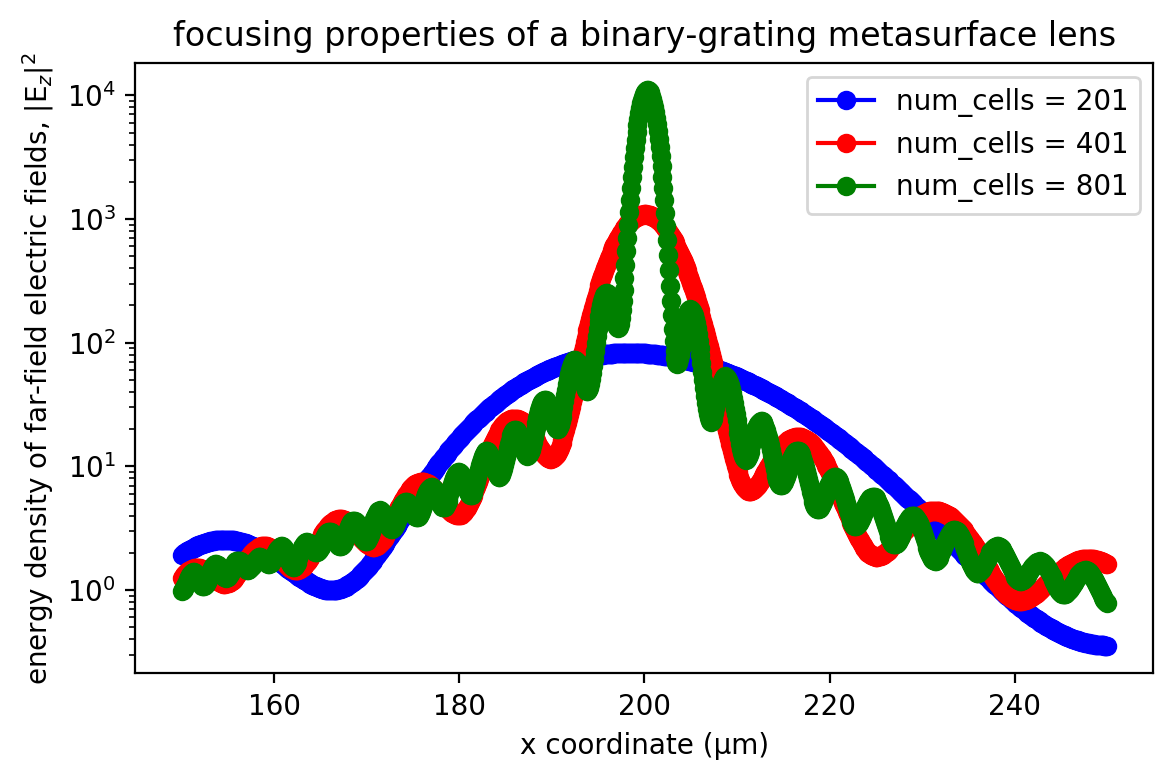

In [5]:
x = np.linspace(focal_length-0.5*spot_length,focal_length+0.5*spot_length,ff_res*spot_length)
plt.figure(dpi=200)
plt.semilogy(x,abs(ff_nc[:,0])**2,'bo-',label='num_cells = {}'.format(2*num_cells[0]+1))
plt.semilogy(x,abs(ff_nc[:,1])**2,'ro-',label='num_cells = {}'.format(2*num_cells[1]+1))
plt.semilogy(x,abs(ff_nc[:,2])**2,'go-',label='num_cells = {}'.format(2*num_cells[2]+1))
plt.xlabel('x coordinate (μm)')
plt.ylabel(r'energy density of far-field electric fields, |E$_z$|$^2$')
plt.title('focusing properties of a binary-grating metasurface lens')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()